#### Model compression Experiment by SKA
 (22.09.2021) 

In [1]:
import torch
import torch.nn as nn
import torchvision

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import tqdm
from collections import defaultdict
from IPython.display import clear_output
import time

### 1. Model of ResNet for student and teacher

In [2]:
class BasicBlock(torch.nn.Module):
    
    """
    Basic Block for resnet-18 and resnet-34 
    """
    
    expansion = 1
    
    def __init__(self, 
                in_channels,
                out_channels,
                stride = 1):
        super().__init__()
        
        #residual function
        self.residual_function = torch.nn.Sequential(
            torch.nn.Conv2d(in_channels, out_channels, kernel_size=3, stride =stride ,padding = 1,bias =False),
            torch.nn.BatchNorm2d(out_channels),
            torch.nn.ReLU(inplace=True),
            torch.nn.Conv2d(out_channels,out_channels*BasicBlock.expansion, kernel_size=3, padding = 1, bias=False),
            torch.nn.BatchNorm2d(out_channels*BasicBlock.expansion)
            
        )
        
        self.shortcut = torch.nn.Sequential()
        
        #the shortcut output dimension is not the same with residual function
        #use 1x1 conv to match
        if stride !=1 or in_channels != BasicBlock.expansion *out_channels:
            self.shortcut = torch.nn.Sequential(
                torch.nn.Conv2d(in_channels,out_channels*BasicBlock.expansion,kernel_size=1,stride=stride,bias=False),
                torch.nn.BatchNorm2d(out_channels*BasicBlock.expansion)
            )
            
    def forward(self, x):
        return torch.nn.ReLU(inplace=True)(self.residual_function(x) + self.shortcut(x))

In [3]:
class BottleNeck(nn.Module):
    
    """
    Residual block for resnet over 50 layers
    """
    
    expansion = 4
    
    def __init__(self, in_channels, out_channels, stride=1):
        super().__init__()
        
        self.residual_function = torch.nn.Sequential(
            
            torch.nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=False),
            torch.nn.BatchNorm2d(out_channels),
            torch.nn.ReLU(inplace=True),
            
            torch.nn.Conv2d(out_channels, out_channels, stride=stride, kernel_size=3, padding=1, bias=False),
            torch.nn.BatchNorm2d(out_channels),
            torch.nn.ReLU(inplace=True),
            
            torch.nn.Conv2d(out_channels, out_channels * BottleNeck.expansion, kernel_size=1, bias=False),
            torch.nn.BatchNorm2d(out_channels * BottleNeck.expansion),
            
        )

        self.shortcut = nn.Sequential()

        if stride != 1 or in_channels != out_channels * BottleNeck.expansion:
            self.shortcut = nn.Sequential(
                torch.nn.Conv2d(in_channels, out_channels * BottleNeck.expansion, stride=stride, kernel_size=1, bias=False),
                torch.nn.BatchNorm2d(out_channels * BottleNeck.expansion)
            )

    def forward(self, x):
        return torch.nn.ReLU(inplace=True)(self.residual_function(x) + self.shortcut(x))


In [4]:
class ResNet(nn.Module):

    def __init__(self, block, num_block, num_classes=100, proj_dim=2048):
        super().__init__()

        self.in_channels = 64

        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True))
        #we use a different inputsize than the original paper
        #so conv2_x's stride is 1
        self.conv2_x = self._make_layer(block, 64, num_block[0], 1)
        self.conv3_x = self._make_layer(block, 128, num_block[1], 2)
        self.conv4_x = self._make_layer(block, 256, num_block[2], 2)
        self.conv5_x = self._make_layer(block, 512, num_block[3], 2)
        self.avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)

        
    def _make_layer(self, block, out_channels, num_blocks, stride):
        """make resnet layers(by layer i didnt mean this 'layer' was the
        same as a neuron netowork layer, ex. conv layer), one layer may
        contain more than one residual block
        Args:
            block: block type, basic block or bottle neck block
            out_channels: output depth channel number of this layer
            num_blocks: how many blocks per layer
            stride: the stride of the first block of this layer
        Return:
            return a resnet layer
        """

        # we have num_block blocks per layer, the first block
        # could be 1 or 2, other blocks would always be 1
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_channels, out_channels, stride))
            self.in_channels = out_channels * block.expansion

        return nn.Sequential(*layers)

    def forward(self, x):
        output = self.conv1(x)
        output = self.conv2_x(output)
        output = self.conv3_x(output)
        output = self.conv4_x(output)
        output = self.conv5_x(output)
        output = self.avg_pool(output)
        representation = output.view(output.size(0), -1)
        output = self.fc(representation)

        return output, representation

In [5]:
def resnet18():
    """ return a ResNet 18 object
    """
    return ResNet(BasicBlock, [2, 2, 2, 2])

def resnet20():
    return ResNet(BasicBlock, [3,3,3])

def resnet34():
    """ return a ResNet 34 object
    """
    return ResNet(BasicBlock, [3, 4, 6, 3])

def resnet50():
    """ return a ResNet 50 object
    """
    return ResNet(BottleNeck, [3, 4, 6, 3])

def resnet101():
    """ return a ResNet 101 object
    """
    return ResNet(BottleNeck, [3, 4, 23, 3])

def resnet152():
    """ return a ResNet 152 object
    """
    return ResNet(BottleNeck, [3, 8, 36, 3])

### 2. Data Preprocessing

In [6]:
def transform_train():
    normalize = torchvision.transforms.Normalize(mean = [0.5071, 0.4867, 0.4408],
                                   std=[0.2675, 0.2565, 0.2761])
    return  torchvision.transforms.Compose([
        torchvision.transforms.RandomHorizontalFlip(),
        torchvision.transforms.ToTensor(),
        normalize
    ])


def transform_test():
    normalize = torchvision.transforms.Normalize(mean = [0.5071, 0.4867, 0.4408],
                                   std=[0.2675, 0.2565, 0.2761])
    return  torchvision.transforms.Compose([
        torchvision.transforms.ToTensor(),
        normalize
    ])


In [7]:
train_dataset = torchvision.datasets.CIFAR100(root = "./diplome_data", train = True, transform = transform_train(), download=True)

val_dataset = torchvision.datasets.CIFAR100(root="./diplome_data",train=False, transform =  transform_test(), download=True)

  0%|          | 0/169001437 [00:00<?, ?it/s]

Extracting ./diplome_data/cifar-100-python.tar.gz to ./diplome_data
Files already downloaded and verified


In [8]:
sampler = torch.utils.data.SubsetRandomSampler(np.arange(len(train_dataset)))
train_loader = torch.utils.data.DataLoader(train_dataset,batch_size=64,sampler = sampler)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size =64, shuffle=True)

### 3. Teacher Training

In [9]:
import resnet
PATH = "/content/resnet20-cifar100.1.state_dict"
model_teacher =  resnet.resnet20()
model_teacher.load_state_dict(torch.load(PATH))
model_teacher.eval();
model_teacher.requires_grad_(False);

The Teacher has the final linear layer 64-> 100, for simplify computation one can remove the final block and then one can directly work with representations of teacher's network

Now, model_teacher will output the tensor, which size is equal to [batch_size, 64]

### 4. Student Training

The size of representations of student network is not equal to teacher's. However, one would like to transfer knowledge. To tackle the problem one can use the following method https://arxiv.org/pdf/1905.00414.pdf, that can work with different size of reperesentations, don't using encoders, flows, PCA and so on and so forth

In [10]:
def hsic(p, q):
    p = p @ p.T
    q = q @ q.T
    n = p.shape[0]
    E = torch.eye(n) - torch.ones((n, n)) / n
    E = E.to(p.device)
    return torch.trace(p @ E @ q @ E) / (n - 1) ** 2

def cka(p, q):
    return hsic(p, q) / hsic(p, p).sqrt() / hsic(q, q).sqrt()

In [11]:
def plot_learning_curves(history):

  fig = plt.figure(figsize=(10,10))

  plt.subplot(3,1,1)
  plt.plot(history['train']['full_loss'], label = 'full_loss')
  plt.plot(history['train']['task_loss'], label=  'task_loss')
  plt.plot(history['train']['reg_loss'],  label=  'reg_loss' )
  plt.plot(history['val']['loss']      ,  label = 'val_loss' )
  plt.xlabel('num_epochs')
  plt.ylabel('loss')
  plt.legend()

  plt.subplot(3,1,2)
  plt.plot(history['train']['acc'],  label='accuracy train' )
  plt.plot(history['val']['acc'],label = 'val_acc')
  plt.xlabel('num_epochs')
  plt.ylabel('accuracy')
  plt.legend()

  plt.subplot(3,1,3)
  plt.plot(history['stmin']['stmin'],label='anchor-negative')
  plt.plot(history['stplus']['stplus'],label='anchor-positive')
  plt.axhline(0,label="postive_border",color='red')
  plt.axhline(2,label="negative_border",color='red')
  plt.xlabel("num iterations")
  plt.ylabel("loss values")
  plt.legend()

  plt.show()

In [12]:
def train_loss_for_student( num_epochs,
                            model_teacher,
                            model_student,
                            optimizer_student,
                            train_loader,
                            val_loader,
                            device,
                            triplet_loss,
                            ce_reg,
                            contr_reg,
                            epoch_unfreezing = 2):
  
    
    model_student.to(device)
    model_teacher.to(device)
    history = defaultdict(lambda: defaultdict(list))


    for epoch in tqdm.notebook.tqdm(range(num_epochs)):

        train_loss_full = 0
        train_loss_task = 0
        train_loss_reg  = 0
        train_acc = 0

        val_loss = 0
        val_acc =  0

     

        start_time = time.time()
        
        model_student.train(True)
        model_student.requires_grad_(True)

        model_teacher.train(False) # eval
        model_teacher.requires_grad_(False)
        
        for batch_x, batch_y in  train_loader:

            optimizer_student.zero_grad()
            output,representation_student = model_student(batch_x.to(device))
            loss_task = ce_reg*torch.nn.CrossEntropyLoss()(output, batch_y.long().to(device))
           
            if epoch > epoch_unfreezing:
 
                _, representation_teacher = model_teacher(batch_x.to(device))#.squeeze()

                #teacher_naoborot = model_teacher(batch_x.flip(dims=[0]).to(device))#.squeeze()
                #teacher_naoborot = representation_teacher.flip(0)
                teacher_naoborot = representation_teacher[torch.randperm(len(batch_x), device=device)]
  
                #print((1 - cka(representation_student, teacher_naoborot)).item())
                history['stmin']['stmin'].append((1 - cka(representation_student, teacher_naoborot)).item())
                history['stplus']['stplus'].append( (1 -  cka(representation_student, representation_teacher) ).item() )

                contr_loss = triplet_loss(representation_student, representation_teacher, teacher_naoborot )

                loss_full = loss_task + contr_reg*contr_loss
                loss_full.backward(retain_graph = False)
                optimizer_student.step()

                train_loss_full += loss_full.item()
                train_loss_task += loss_task.item() 
                train_loss_reg  += (loss_full.item() - loss_task.item())
            else:
 
                loss_task.backward(retain_graph = False)
                optimizer_student.step()
                
                train_loss_full += loss_task.item()
                train_loss_task += loss_task.item() - 0.0001 # custom for visualization
                train_loss_reg  += 0.0 # custom for visualization

            y_pred_train_st = output.argmax(1).cpu().detach()
            train_acc += (batch_y == y_pred_train_st ).float().mean()
        
        train_loss_full /= len(train_loader)
        train_loss_task /= len(train_loader)
        train_loss_reg /=  len(train_loader)
        train_acc /= len(train_loader)

        history['train']['full_loss'].append(train_loss_full)
        history['train']['task_loss'].append(train_loss_task)
        history['train']['reg_loss'].append(train_loss_reg)
        history['train']['acc'].append(train_acc)
 


        # validation
        model_student.eval()
        with torch.no_grad():
          for batch_x, batch_y in val_loader:
            output,_ = model_student(batch_x.to(device))

            y_val_st = output.argmax(1).cpu()
            #print(batch_y.shape, y_val_st.shape)

            val_acc += (batch_y == y_val_st).float().mean()
            val_loss += torch.nn.CrossEntropyLoss()(output,batch_y.long().to(device))
          
          val_loss /= len(val_loader)
          val_acc /= len(val_loader)

          history['val']['loss'].append(val_loss)
          history['val']['acc'].append(val_acc)
          
          clear_output()
          plot_learning_curves(history)

          
    return model_student, history

                
            


         

In [13]:
NUM_EPOCHS = 50
EPOCH_UNFREEZING = 0
LR = 1e-3
MARGIN = 0.1
CE_REG =1
CONTR_REG = 1
model_student = resnet.resnet14()
optimizer_student =torch.optim.Adam(model_student.parameters(),lr=LR)
TRIPLET_LOSS = torch.nn.TripletMarginWithDistanceLoss\
(distance_function=lambda x, y: 1.0 - cka(x, y), margin = MARGIN, reduction = 'mean') # margin=0.5?

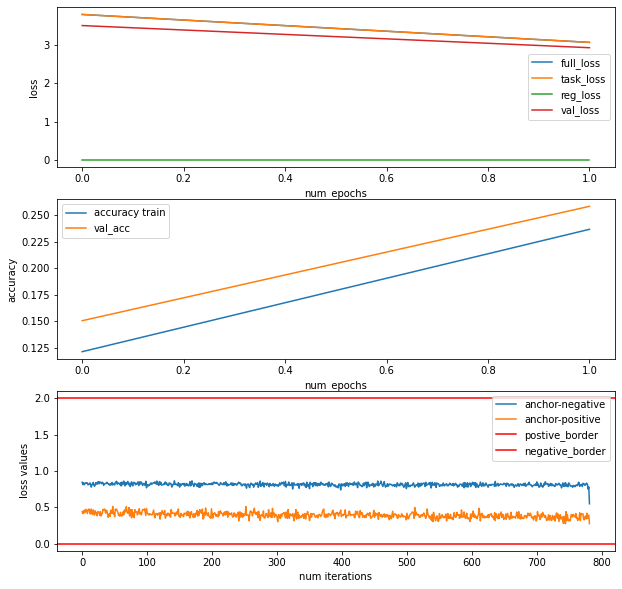

KeyboardInterrupt: ignored

In [16]:
model,history =  train_loss_for_student( num_epochs = NUM_EPOCHS,
                           model_teacher = model_teacher,
                           model_student = model_student,
                           optimizer_student = optimizer_student,
                           train_loader = train_loader,
                           val_loader = val_loader,
                           device = 'cuda',
                           triplet_loss = TRIPLET_LOSS,
                           ce_reg = CE_REG,
                           contr_reg= CONTR_REG,
                           epoch_unfreezing = EPOCH_UNFREEZING )

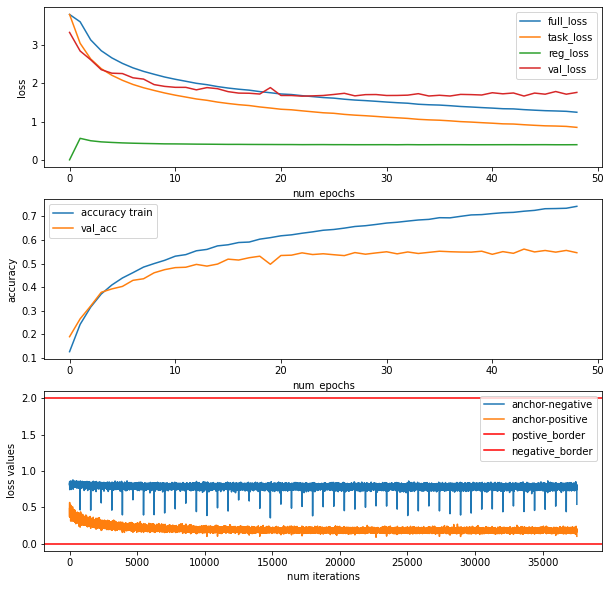

KeyboardInterrupt: ignored

In [ ]:
model,history =  train_loss_for_student( num_epochs = NUM_EPOCHS,
                           model_teacher == mdel_teacher,
                           model_student = model_student,
                           optimizer_student = optimizer_student,
                           train_loader = train_loader,
                           val_loader = val_loader,
                           device = 'cuda',
                           triplet_loss = TRIPLET_LOSS,
                           ce_reg = CE_REG,
                           contr_reg= CONTR_REG,
                           epoch_unfreezing = EPOCH_UNFREZZING )

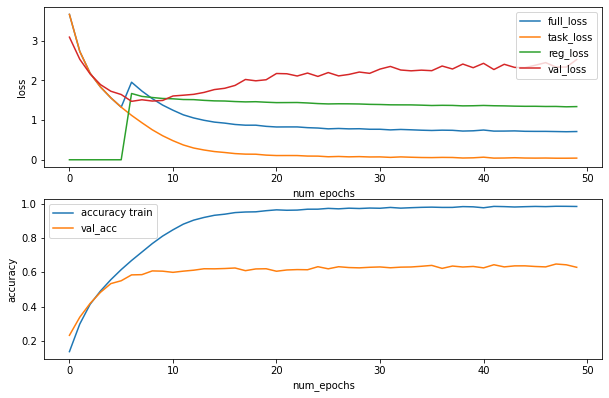

In [ ]:
model,history = train_loss_for_student( num_epochs,
                           model_teacher,
                           model_student,
                           optimizer_student,
                           train_loader,
                           val_loader,
                           device = 'cuda',
                           triplet_loss = triplet_loss,
                           ce_reg = 1,
                           contr_reg= 2,
                           epoch_unfreezing = epoch_unfreezing )

#torch.save(model,"/content/drive/MyDrive/Transfer_CKA/model_ce_reg.pt")
#torch.save(history['val']['acc'],"/content/drive/MyDrive/Transfer_CKA/history_ce_reg.pt")

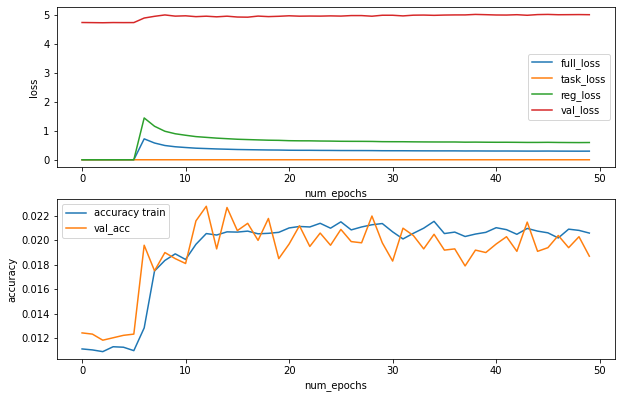

In [ ]:
model_student = resnet18()
optimizer_student =torch.optim.Adam(model_student.parameters(),lr=1e-3)
model,history = train_loss_for_student( num_epochs,
                           model_teacher,
                           model_student,
                           optimizer_student,
                           train_loader,
                           val_loader,
                           device = 'cuda',
                           triplet_loss = triplet_loss,
                           ce_reg = 0,
                           contr_reg= 1,
                           epoch_unfreezing = epoch_unfreezing )

#torch.save(model,"/content/drive/MyDrive/Transfer_CKA/model_reg.pt")
#torch.save(history,"/content/drive/MyDrive/Transfer_CKA/history_reg.pt")